# Aldous Numerics

In [1]:
include("CTMC_methods.jl");
using LinearAlgebra
using Distributions
using Plots

## Aldous scheme
Procedure:

- Generate random variables (uniform/exponential)
- Travel to starting state
- Determine occupation and update occupation measure/normalizer
- Travel to following state
- If state is in the subset of absorbing states, change state to random state via. occupation measure
- repeat steps for fixed (time/jumps)

Soft killing uses minimum of exponentials (heuristically seperate from movement of particle)
Inherits methods from CTMC_methods.jl


In [26]:
function kill(occupation_measure, time, r)
    # After killing, determines what state to travel to based on the occupation measure / time
    
    # Validate occupation measure
    epsilon = 0.01
    if abs(sum(occupation_measure) - time) > epsilon
        throw(DomainError(time, "Issues with given occupation measure and time"))
    end

    # Resample via occupation_measure (occupation measure will be zero on absorbed states)
    r = r * time
    for i in 1:n_states
        r -= occupation_measure[i]
        if r <= 0
            return i
        end
    end
    return n_states
end

function aldous(n_samples, n_states, Q, absorbing)
    # Initialize random vectors
    continuation = setdiff(1:n_states, absorbing) # Continuation states
    x = randexp(rng, n_samples)
    r = rand(rng, n_samples)
    y = zeros(Int8, n_samples)
    num_kills = 0
    occupation_measure = zeros(Float64, n_states)
    
    # Iterate Aldous process
    a = Plots.Animation()
    y[1] = rand(continuation)
    x[1] = 0

    Qᵗ = transpose(Q)
    vals = eigvals(Qᵗ)
    vecs = eigvecs(Qᵗ)
    pf_eig, pf_index = findmax(vals)
    vec = vecs[: , pf_index]
    vec = vec ./ norm(vec, 1)
    
    @time for i in 2:n_samples
        # Determine occupation time
        occupation_measure[y[i-1]] += x[i] / -Q[y[i-1], y[i-1]]

        # Plotting
        if i % 800 == 0
            plt = plot(occupation_measure, xlim=(0, n_states+1), 
                color = ifelse.(1:n_states .== y[i-1], :red, :blue), lab="Aldous Particles")
            plot!(plt, vec.* x[i-1], color="red", lab = "Stationary Distribution")
            Plots.annotate!(0, 0, text(string(i), :red, :left, 10))    
            frame(a, plt)
        end
        if i % 50000 == 0
            @printf "Step [%i / %i].\n" i n_samples
        end
            
        # Evolve state
        x[i] = x[i-1] + x[i] / -Q[y[i-1], y[i-1]]
        y[i] = state(y[i-1], Q, r[i])

        # If absorbed, move to a random location based on occupation time
        if y[i] in absorbing
            y[i] = kill(occupation_measure, x[i], rand(rng))
            num_kills += 1
        end
    end
    display(gif(a, "aldous.gif"))
    return x, y, occupation_measure, num_kills
end

aldous (generic function with 1 method)

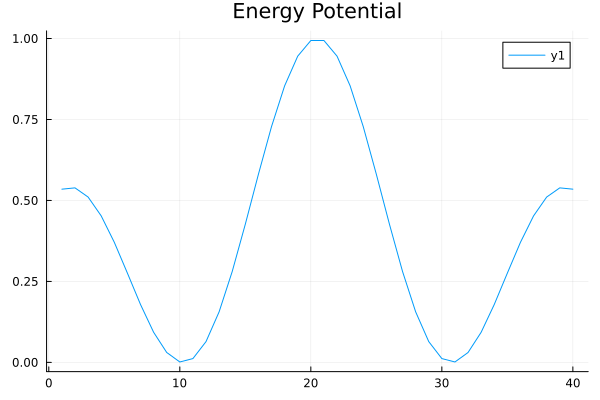

2-element Vector{Int64}:
  1
 40

In [27]:
### Transition Parameters
const n_states = 40
const n_samples = 500000
# λ = 1
# μ = 1
# Q = birth_death(n_states, μ, λ)
function f(x)
    return - 4 * x * (x-1)
end
function g(x)
    return 1 - sin(2 * π * x)^2
end
function J(x)
    return g(x/(n_states + 1)) * (.5 + .5 * f(x / (n_states+1)))
end
J_vect = map(J, 1:n_states)
display(plot(1:n_states, J_vect, title="Energy Potential"))
# display(plot(1:n_states, map(x -> exp(-x), J_vect), title="Energy Potential"))
Q = rates_energy_potential(J_vect)
absorbing = [1, n_states]

Step [50000 / 500000].
Step [100000 / 500000].
Step [150000 / 500000].
Step [200000 / 500000].
Step [250000 / 500000].
Step [300000 / 500000].
Step [350000 / 500000].
Step [400000 / 500000].
Step [450000 / 500000].
Step [500000 / 500000].
  9.682961 seconds (12.62 M allocations: 421.843 MiB, 0.16% gc time, 0.09% compilation time)


[ Info: Saved animation to /Users/azul/Documents/Numerics/QSD/aldous.gif


Plots.AnimatedGif("/Users/azul/Documents/Numerics/QSD/aldous.gif")
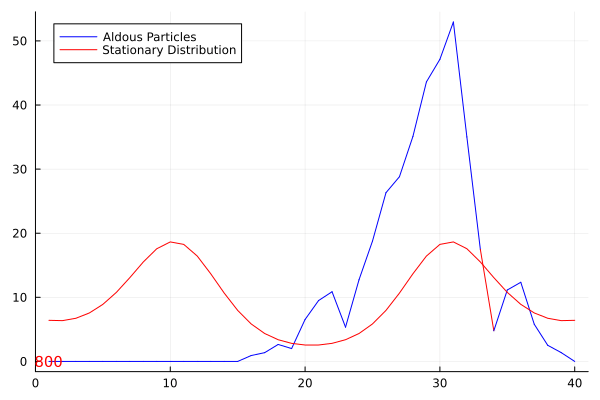

Times Killed: 1643

In [28]:
x, y, occupation_measure, num_kills = aldous(n_samples, n_states, Q, absorbing)

@printf "Times Killed: %i" num_kills
# p = barplot(1:n_states, occupation_measure, title="Aldous Occupation Measure")
# display(p)